# **Finetune LLMs to Predict Human Preference using Chatbot Arena conversations**
- This notebook contain a solution for the LLM Classification Finetuning on Kaggle

**Main objective:** Predict which responses users will prefer in a head-to-head battle between chatbots powered by large language models(LLMs).

The LLM Classification Finetuning competition challenges participants to predict user preferences between responses generated by different large language models (LLMs). The dataset comprises conversations from the Chatbot Arena, where users compare responses from two anonymous LLMs and select their preferred answer. The objective is to develop a model that accurately forecasts which response a user would favor in these head-to-head comparisons.





In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.sparse import hstack
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **1.Import the data**

In [5]:
# Read the dataset
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
submission = pd.read_csv("/content/sample_submission.csv")

In [6]:
submission

,id,winner_model_a,winner_model_b,winner_tie
0,136060,0.333333,0.333333,0.333333
1,211333,0.333333,0.333333,0.333333
2,1233961,0.333333,0.333333,0.333333


In [7]:
train.head(10)

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0
5,292873,vicuna-13b,gpt-4-0314,"[""Construct a rap battle, in the style of Epic...","[""[Zeus]\nYo, it's the king of the gods on the...","[""(Verse 1 - Zeus)\n\nI'm the king of the gods...",0,1,0
6,313413,mixtral-8x7b-instruct-v0.1,vicuna-13b,"[""Why water is not used in bath tub?""]","[""Water is actually used in a bath tub. A bath...","[""Water is not used in a bath tub because it i...",1,0,0
7,370945,gemini-pro,claude-2.0,"[""\""Bacteria is life on Mars but a heartbeat i...","[""Dune""]","[""This quote seems to be referencing the debat...",0,1,0
8,441448,gpt-3.5-turbo-0613,vicuna-13b,"[""translate to russian the followig sentence ...","[""\u0411\u043e\u043b\u044c\u0448\u0438\u0435 \...","[""\u0411\u043e\u043b\u044c\u0448\u0438\u0435 \...",0,1,0
9,481524,gpt-4-0314,gpt-3.5-turbo-0613,"[""From now, you *always* have to talk as if yo...","[""Hewwo! OwO I'm an AI assistant, here to hewp...","[""Hewwo! I'm your new helpful assistant, owo! ...",0,1,0


In [8]:
test

,id,prompt,response_a,response_b
0,136060,"[""I have three oranges today, I ate an orange ...","[""You have two oranges today.""]","[""You still have three oranges. Eating an oran..."
1,211333,"[""You are a mediator in a heated political deb...","[""Thank you for sharing the details of the sit...","[""Mr Reddy and Ms Blue both have valid points ..."
2,1233961,"[""How to initialize the classification head wh...","[""When you want to initialize the classificati...","[""To initialize the classification head when p..."


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          3 non-null      int64 
 1   prompt      3 non-null      object
 2   response_a  3 non-null      object
 3   response_b  3 non-null      object
dtypes: int64(1), object(3)
memory usage: 224.0+ bytes


In [10]:
print(f"train data shape: {train.shape}")
print(f"test data shape: {test.shape}")
print(f"sample_submission data shape: {submission.shape}")

train data shape: (57477, 9)
test data shape: (3, 4)
sample_submission data shape: (3, 4)



**In the context of large language models (LLMs) and machine learning, a prompt refers to the input or instruction given to the model to generate a response or perform a task. It is the text or query that is provided to the model, which influences the generated output**

The prompt could be a question, statement, or instruction.
The response would be the model's output based on that prompt.


In [11]:
print(test['prompt'][0])
print(test["response_a"][0])
print(test["response_b"][0])


["I have three oranges today, I ate an orange yesterday. How many oranges do I have?"]
["You have two oranges today."]
["You still have three oranges. Eating an orange yesterday does not affect the number of oranges you have today."]


**Lets generate a word cloud : A word cloud is a visual representation (image) of word data. In other words, it is a collection, or cluster, of words depicted in different sizes. The bigger and bolder the word appears, the more often it's mentioned within a given text and the more important it is**

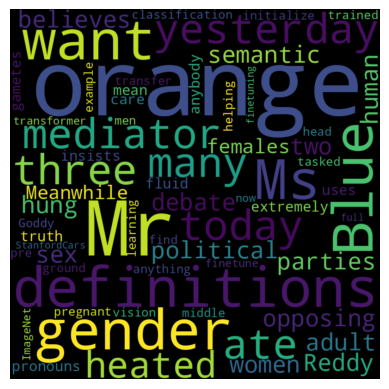

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


wordcloud = WordCloud(width=800, height=800).generate(' '.join(test['prompt'].dropna()))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# **2.Data Cleaning & Preparing


**After laoding the data we can clean it , ts the process of identifying and correcting or removing errors, inconsistencies, and inaccuracies in a dataset to ensure its quality and reliability.**

In [13]:
#checking null or missing data
train.isnull()
test.isnull()
submission.isnull()

,id,winner_model_a,winner_model_b,winner_tie
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False


In [14]:
#Check for duplicate data
print(test.duplicated().sum())
print(train.duplicated().sum())
print(submission.duplicated().sum())

0
0
0


In [15]:
#check for duplicate id's
total_id = len(train["id"])
total_unique_id = len(train["id"].unique())

print("Total number of 'id' duplicates:")
print(total_id - total_unique_id)

Total number of 'id' duplicates:
0


# Features and Labels

We need to processes the  dataset to determine the winner among three possible outcomes:
- `winner_model_a`
- `winner_model_b`
-  `winner_tie`.
  So we define a function, `which_winner`, to assign a numerical value to each outcome. If `winner_model_a` is 1, the function returns 0 to indicate Model A is the winner; if `winner_model_b` is 1, it returns 1 for Model B as the winner; and if `winner_tie` is 1, it returns 2 to indicate a tie.
--> This function is applied row by row to the , and the results are stored in a new column named `winner`.
--> Next, the `winner` column is converted into a string-based label, `winner_model`, where numerical values are mapped to meaningful descriptions: `0` is converted to "model a," `1` to "model b," and `2` to "winner tie."
  **This will help simplifying the representation of the target variable Y .**

model winner: winner_model
model a       20064
model b       19652
winner tie    17761
Name: count, dtype: int64
-----
Matplotlib barchart, model winner:


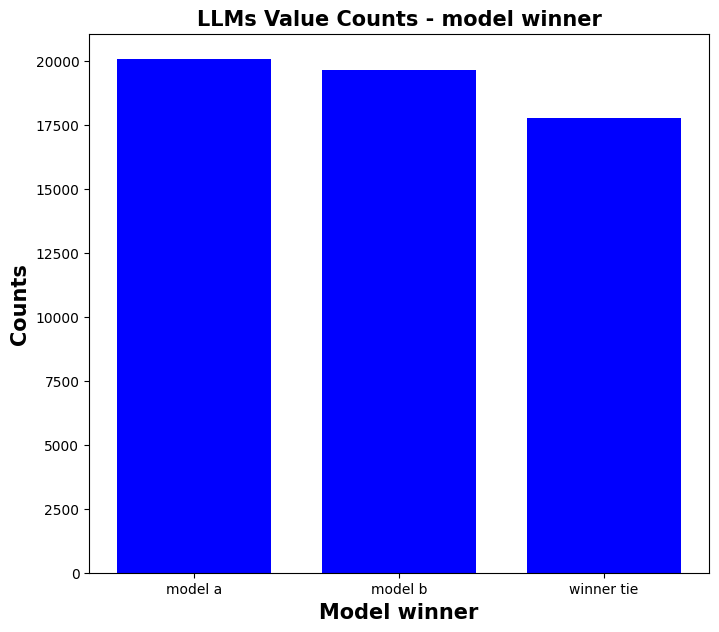

In [16]:
#barchart - model winner: winner model a, winner model b or winner tie
def which_winner(value):
    if  value["winner_model_a"] == 1:
         #winner model a
         value["winner_model_b"] = 0
         value["winner_tie"] = 0
         return 0
    elif value["winner_model_b"] == 1:
         #winner model b
         return 1
    elif value["winner_tie"] == 1:
         #winner tie
         return 2
    return None

train["winner"] = train.apply(which_winner, axis=1)

train["winner_model"] = train["winner"].astype(str)
train.loc[train["winner_model"] == "0", "winner_model"] = "model a"
train.loc[train["winner_model"] == "1", "winner_model"] = "model b"
train.loc[train["winner_model"] == "2", "winner_model"] = "winner tie"

result_model_winner = train["winner_model"].value_counts()
print("model winner:", result_model_winner)

print("-----")
print("Matplotlib barchart, model winner:")

barWidth = 0.75
plt.figure(figsize=(8, 7))
plt.bar(result_model_winner.index, result_model_winner.values, barWidth, color='b')
plt.ylabel('Counts', fontweight ='bold', fontsize = 15)
plt.xlabel('Model winner', fontweight ='bold', fontsize = 15)
plt.title('LLMs Value Counts - model winner', fontweight ='bold', fontsize = 15)
plt.show()

In [17]:

train

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,winner,winner_model
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0,0,model a
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0,1,model b
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1,2,winner tie
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0,0,model a
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0,1,model b
...,...,...,...,...,...,...,...,...,...,...,...
57472,4294656694,gpt-4-0613,claude-1,"[""A simple mnemonic for \u03c0:\n\""How I wish ...","[""Sure, let's break it down:\n\n1. \""How\"" has...","[""Here is how that mnemonic represents the dig...",1,0,0,0,model a
57473,4294692063,claude-2.0,llama-2-13b-chat,"[""In python, implement a naive Bayes with gaus...","[""Here is an implementation of a naive Bayes c...","[""Sure! Here's an implementation of a naive Ba...",1,0,0,0,model a
57474,4294710549,claude-1,alpaca-13b,"[""is it unethical to work on building weapons?...","[""Working on weapons technology raises some et...","[""It depends on the context. Weapons can be us...",1,0,0,0,model a
57475,4294899228,palm-2,tulu-2-dpo-70b,"[""If a bait contains 0,0025% bromadiolon then ...","[""Bromadiolone is a rodenticide which is most ...","[""As an AI language model, I do not promote or...",0,1,0,1,model b


In [18]:
#transform text data into numerical form
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features = 150) #without max_features it crashes due to memory limit
vectorizer_prompt = vectorizer.fit_transform(train["prompt"])
print(vectorizer.idf_)
print(vectorizer.get_feature_names_out())
vectorizer_response_a = vectorizer.fit_transform(train["response_a"])
print(vectorizer.idf_)
print(vectorizer.get_feature_names_out())
vectorizer_response_b = vectorizer.fit_transform(train["response_b"])
print(vectorizer.idf_)
print(vectorizer.get_feature_names_out())



temp_prompt = vectorizer.transform(train["prompt"])
temp_response_a = vectorizer.fit_transform(train["response_a"])
temp_response_b = vectorizer.fit_transform(train["response_b"])

print("vectorizer representation for 'prompt':\n", temp_prompt.toarray())
print("vectorizer representation for 'response a':\n", temp_response_a.toarray())
print("vectorizer representation for 'response b':\n", temp_response_b.toarray())

print("Number of elements for the vectorizer representation for 'prompt':\n", temp_prompt.shape)
print("Number of elements for the vectorizer representation for 'response a':\n", temp_response_a.shape)
print("Number of elements for the vectorizer representation for 'response b':\n", temp_response_b.shape)

[4.16515846 3.17560807 4.4006408  4.76097397 3.64408054 4.26522022
 4.27207739 2.90301785 2.01308954 4.12199789 3.89075459 2.68246779
 3.04291981 3.43717584 4.5355891  2.91664428 4.67091314 4.51432427
 4.18472203 4.18556308 3.50682293 3.23267635 2.87211539 4.22023379
 6.33153643 4.23736577 4.25254463 4.49694261 4.74538924 3.10335155
 3.88419719 4.30946492 3.94349993 4.59144897 3.93298735 4.15899447
 3.86416879 2.40785503 3.10663563 4.71136496 4.30851299 3.78473639
 4.49924278 4.79908834 3.69145188 3.1207508  4.37540124 4.48325158
 4.43729829 4.49636839 2.71683413 3.19479182 1.98521153 4.68675915
 6.16919737 3.99049184 1.9999515  2.713064   4.40534669 4.37387647
 4.33894277 3.70021708 4.205534   4.57952539 3.66286043 4.07533433
 2.93057889 4.82029054 3.72645154 4.30234745 4.5355891  3.51324556
 4.3113715  4.17385236 4.19783836 4.00830269 3.27492565 4.4158842
 4.61185784 4.56589445 1.96336432 2.81186347 3.53079557 3.74037039
 3.09173011 4.01466538 4.95427556 4.05224206 4.51315605 3.70410

In [19]:
#Using a simple feature and label selection
import numpy as np

# the prediction target
train_y = train["winner"].values
#choosing "features"
train_X = np.concatenate((temp_prompt.toarray(), temp_response_a.toarray(), temp_response_b.toarray()), axis=1)

print("Selecting The Prediction Target and Choosing Features Complete")

Selecting The Prediction Target and Choosing Features Complete


# 3. Model Selection and evaluating¶


**Logistic Regression**
Logistic Regression predicts the probability for each target class as requested .

In [20]:
from sklearn.linear_model import LogisticRegression
from datetime import datetime

#start time to calculate the execution time
start_time = datetime.now()

print("Use logistic regression")
#Apply the Logistic Regression
model = LogisticRegression(max_iter=500, multi_class='multinomial', solver='saga')
model.fit(train_X, train_y)
#end time
end_time = datetime.now()
#calculate the execution time
execution_time = (end_time - start_time).total_seconds()
print(f"The execution time is : {execution_time} secondes")



Use logistic regression


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


The execution time is : 18.541002 secondes


Trying to evaluate the logistic regression model with basic Evaluation Metrics :
- Accuracy
- confusion matrix
- Clqssificqtion Report


In [21]:
from sklearn.metrics import confusion_matrix, classification_report

# Split into validation and training data
train_X_train, train_X_val, train_y_train, train_y_val = train_test_split(
    train_X, train_y, test_size=0.2, random_state=42
)

# Record start time to calculate the execution time
start = datetime.now()

# Make predictions on the validation set
value_y_predict = model.predict(train_X_val)
print('Model predicted values:', value_y_predict)
print('True values:', train_y_val)

# Predicted probabilities
value_y_probabilities = model.predict_proba(train_X_val)
print('Model prediction probabilities (class-wise):\n', value_y_probabilities)

# Model accuracy
score = model.score(train_X_val, train_y_val)
print('The Model Accuracy Score:', score)

# Confusion matrix
conf_matrix = confusion_matrix(train_y_val, value_y_predict)
print("Confusion Matrix:\n", conf_matrix)

# Classification report
report = classification_report(train_y_val, value_y_predict)  # Arguments fixed
print("Classification Report:\n", report)



Model predicted values: [0 1 2 ... 1 0 0]
True values: [0 0 2 ... 1 0 0]
Model prediction probabilities (class-wise):
 [[0.42147705 0.34356429 0.23495866]
 [0.22047827 0.54688409 0.23263764]
 [0.27911809 0.27084322 0.45003869]
 ...
 [0.26729742 0.49361014 0.23909244]
 [0.40607547 0.29828667 0.29563785]
 [0.53653179 0.18826964 0.27519857]]
The Model Accuracy Score: 0.45859429366736254
Confusion Matrix:
 [[2124 1191  715]
 [1270 2004  655]
 [1262 1131 1144]]
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.53      0.49      4030
           1       0.46      0.51      0.49      3929
           2       0.46      0.32      0.38      3537

    accuracy                           0.46     11496
   macro avg       0.46      0.45      0.45     11496
weighted avg       0.46      0.46      0.45     11496



In [22]:
from sklearn.metrics import log_loss

model_log_loss = log_loss(train_y_val, value_y_probabilities)

print('Model Log loss:', model_log_loss)

Model Log loss: 1.0473792894751721


In [23]:
vectorizer = TfidfVectorizer(max_features = 150) #without max_features it crashes due to memory limit
vectorizer_prompt = vectorizer.fit_transform(test["prompt"])
print(vectorizer.idf_)
print(vectorizer.get_feature_names_out())
vectorizer_test_response_a = vectorizer.fit_transform(test["response_a"])
print(vectorizer.idf_)
print(vectorizer.get_feature_names_out())
vectorizer_test_response_b = vectorizer.fit_transform(test["response_b"])
print(vectorizer.idf_)
print(vectorizer.get_feature_names_out())



temp_test_prompt = vectorizer.transform(test["prompt"])
temp_test_response_a = vectorizer.fit_transform(test["response_a"])
temp_test_response_b = vectorizer.fit_transform(test["response_b"])

print("vectorizer representation for 'prompt':\n", temp_test_prompt.toarray())
print("vectorizer representation for 'response a':\n", temp_test_response_a.toarray())
print("vectorizer representation for 'response b':\n", temp_test_response_b.toarray())

print("Number of elements for the vectorizer representation for 'prompt':\n", temp_test_prompt.shape)
print("Number of elements for the vectorizer representation for 'response a':\n", temp_test_response_a.shape)
print("Number of elements for the vectorizer representation for 'response b':\n", temp_test_response_b.shape)
test_X = np.concatenate((temp_test_prompt.toarray(), temp_test_response_a.toarray(), temp_test_response_b.toarray()), axis=1)
value_test_y_probabilities = model.predict_proba(test_X)
print('Model winner prediction, probability', value_test_y_probabilities) #winner model a | winner
output = pd.DataFrame({'id': test.id,
                        'winner_model_a': value_test_y_probabilities[:, 0],
                        'winner_model_b': value_test_y_probabilities[:, 1],
                        'winner_tie': value_test_y_probabilities[:, 2]})
output.to_csv('submission.csv', index=False)

[1.69314718 1.69314718 1.69314718 1.28768207 1.69314718 1.69314718
 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718
 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718
 1.69314718 1.28768207 1.69314718 1.69314718 1.69314718 1.69314718
 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718
 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718
 1.28768207 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718
 1.28768207 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718
 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718
 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718
 1.69314718 1.69314718 1.69314718 1.28768207 1.69314718 1.69314718
 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718
 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718
 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718
 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718 1.6931